In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder

import json
import random
from datetime import datetime
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import re

print(tf.__version__)

2.1.0-rc0


In [2]:
SEED = 2019
tf.random.set_seed(SEED)

classes = ['0',             # 0
           '1',             # 1
           '10',            # 2
           '2',             # 3
           '3',             # 4
           '4',             # 5
           '5',             # 6
           '6',             # 7
           '7',             # 8
           '8',             # 9
           '9',             # 10
           'no',            # 11
           'yes']           # 12

PATH = "/kaggle/input/ann-and-dl-vqa/dataset_vqa"

num_labels = 13
batch_size = 128

MAX_SEQUENCE_LENGTH = 43
IMG_HEIGHT, IMG_WIDTH = 128, 192
CLASSIFICATION = False
PRETRAINED_EMBEDDING = False
BALANCE_TRAIN_SET = True

## Load data from json files

In [3]:
with open(os.path.join(PATH, 'train_data.json'), 'r') as f:
    train_data = json.load(f)
f.close()

with open(os.path.join(PATH, 'test_data.json'), 'r') as f:
    test_data = json.load(f)
f.close()

train_data = train_data['questions']
test_data = test_data['questions']

train_dataset_size = len(train_data) # number of questions --> 259492


### format of data

In [4]:
train_data[1:3]

[{'answer': '0',
  'image_filename': 'CLEVR_train_000000.png',
  'question': 'How many gray matte things are on the right side of the small rubber cube behind the large brown thing left of the cyan thing?'},
 {'answer': 'yes',
  'image_filename': 'CLEVR_train_000000.png',
  'question': 'Are there any other things that have the same size as the brown shiny sphere?'}]

# Data Generator

## Tokenizer
The tokenizer translate question made of words into vectors of numbers.
by default the tokenizer get rids of punctuation. This has been avoided by splitting words base only on spaces. 

Answers are preprocessed so as to divide punctuation from words by at least a space.
The number of terms that the tokenizer can be encoded, has to be fixed before start using it. For such a reason questions are extracted and fed into the tokenizer so it can determine all the parametrs that are necessary for its usage. 

In [5]:
def separate_punctuation_from_words(string):
    to_tokenize = '.,:;!?'
    string = re.sub(r'(['+to_tokenize+'])', r' \1 ', string)
    # we had to substitute a unknown term
    return re.sub(r'matte', r'opaque', string)

for i,q in enumerate(train_data):
    train_data[i]['question'] = separate_punctuation_from_words(train_data[i]['question'].lower())

for i,q in enumerate(test_data):
    test_data[i]['question'] = separate_punctuation_from_words(test_data[i]['question'].lower())
    
    


In [6]:
!ls /kaggle/input/20-newsgroup-original/20_newsgroup

20_newsgroup		  misc.forsale	      sci.med
alt.atheism		  rec.autos	      sci.space
comp.graphics		  rec.motorcycles     soc.religion.christian
comp.os.ms-windows.misc   rec.sport.baseball  talk.politics.guns
comp.sys.ibm.pc.hardware  rec.sport.hockey    talk.politics.mideast
comp.sys.mac.hardware	  sci.crypt	      talk.politics.misc
comp.windows.x		  sci.electronics     talk.religion.misc


In [7]:
texts    = [el['question']for el in train_data ]
texts.extend(el['question']for el in test_data )

max_words = max([len(line.split()) for line in texts])
MAX_SEQUENCE_LENGTH = max_words


In [8]:
import sys
from tensorflow.keras.layers import Embedding

def getPretrainedEmbedding():
    
    BASE_DIR = '/kaggle/input/'
    GLOVE_DIR = os.path.join(BASE_DIR, 'glove6b')
    TEXT_DATA_DIR = os.path.join(BASE_DIR, '20-newsgroup-original', '20_newsgroup', '20_newsgroup')

    MAX_NUM_WORDS = 20000
    EMBEDDING_DIM = 100


    # first, build index mapping words in the embeddings set
    # to their embedding vector

    print('Indexing word vectors.')

    embeddings_index = {}
    with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))

    # second, prepare text samples and their labels
    print('Processing text dataset')

    texts = []  # list of text samples
    labels_index = {}  # dictionary mapping label name to numeric id
    labels = []  # list of label ids
    for name in sorted(os.listdir(TEXT_DATA_DIR)):
        path = os.path.join(TEXT_DATA_DIR, name)
        if os.path.isdir(path):
            label_id = len(labels_index)
            labels_index[name] = label_id
            for fname in sorted(os.listdir(path)):
                if fname.isdigit():
                    fpath = os.path.join(path, fname)
                    args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                    with open(fpath, **args) as f:
                        t = f.read()
                        i = t.find('\n\n')  # skip header
                        if 0 < i:
                            t = t[i:]
                        texts.append(t)
                    labels.append(label_id)

    print('Found %s texts.' % len(texts))

    # finally, vectorize the text samples into a 2D integer tensor
    t = Tokenizer(num_words=MAX_NUM_WORDS)
    t.fit_on_texts(texts)
    sequences = t.texts_to_sequences(texts)

    word_index = t.word_index
    print('Found %s unique tokens.' % len(word_index))

    print('Preparing embedding matrix.')

    # prepare embedding matrix
    num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # load pre-trained word embeddings into an Embedding layer
    # note that we set trainable = False so as to keep the embeddings fixed
    
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix),
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    
        
    return t,embedding_layer


def getEmbedding():
    if PRETRAINED_EMBEDDING :
        return getPretrainedEmbedding()
    else:
        EMBEDDING_DIM = 10
        # check that all questions are made with terms that 
        # the embedding is able to use.
        texts    = [el['question']for el in train_data ]
        texts.extend(el['question']for el in test_data )

        max_words = max([len(line.split()) for line in texts])
        words = set( np.concatenate([line.split() for line in texts]))

        t = Tokenizer(num_words=len(words))
        t.fit_on_texts(texts)

        embedding_layer = Embedding(input_dim=len(words)+1,
                                    output_dim=EMBEDDING_DIM,
                                    input_length=MAX_SEQUENCE_LENGTH)
        return t, embedding_layer
        
t, embedding_layer = getEmbedding()

In [9]:
# check that all questions are made with terms that 
# the embedding is able to use.
texts    = [el['question']for el in train_data ]
texts.extend(el['question']for el in test_data )

max_words = max([len(line.split()) for line in texts])
words = set( np.concatenate([line.split() for line in texts]))
print('Found (',len(words),') words in our questions:',words)
print('Questions are at most ',max_words,' word long ')

for w in words:
    if (w in '.,:;!?'):
        continue
    if ( w not in t.word_index ):
        print(w)


Found ( 72 ) words in our questions: {'it', 'that', 'a', 'gray', 'there', 'the', 'tiny', 'thing', 'front', 'are', 'purple', 'balls', 'visible', 'of', 'ball', 'on', 'yellow', 'things', 'rubber', 'another', 'red', 'blue', 'as', 'material', 'has', 'other', 'metallic', 'size', 'sphere', 'cylinders', 'anything', 'big', 'metal', 'any', 'number', 'and', '?', 'left', 'brown', 'green', 'or', 'side', 'opaque', 'small', 'shiny', 'blocks', 'is', 'cyan', 'same', 'cube', 'cubes', 'what', 'cylinder', 'large', 'how', 'behind', 'both', 'color', ';', 'spheres', 'in', 'many', 'shape', 'objects', 'block', 'to', 'have', 'else', 'object', 'made', 'either', 'right'}
Questions are at most  43  word long 


In [10]:
#example of tokenizer usage 
t.texts_to_sequences(['the tiny metallic cylinder ?'])

[[1, 16, 28, 26]]

### MyDataset
this class hide the steps that led to the dataset creation and the split between validation and training set.
This class can be supplied with :
- a predicate that filters the element in json. It is used to acquire a subset of questions related to a certain answer
- a field that indicates what part of each object contained in json variable has to be taken
- a function 'funct' that is executed of the field extracted before building the dataset

In [11]:


class myDataset(tf.data.Dataset):
   
    def __new__(self, json,  output_shapes, output_types, validation_split=0.0,field=None,
                seed=None, subset='training', funct = None, filt=None , verbose=False, randomize=True):
        
        #1. set seed if available
        if(seed is not None):
            tf.random.set_seed(SEED)
            np.random.seed(SEED)
        #2. divide questions in two sets randomly.
        #print(os.listdir(basepath))
           
        self.subset = json
        #if present use a filter
        if filt is not None:
            if(verbose):
                 print('executed: ',filt)
            self.subset = list(filter(filt, self.subset))
        
        if(randomize):
            np.random.shuffle(self.subset)

        split_indx = round( validation_split * len(self.subset) )
        #3. take the part corresponding to to either the validation
        # or the training subset
        if subset == 'validation':
            self.number_of_items = split_indx
            self.subset = self.subset[:split_indx]
            
            
        else :
            self.number_of_items =len(self.subset)- split_indx
            self.subset = self.subset[split_indx:]
            
        
        if(verbose):
            #print number of items carried
            print( self.number_of_items, 'items ingested')
            #print field
            print( 'taking field ', field)
        
        
            
        #extract field from json
        if field is not None:
            self.subset = list(map(lambda el: el[field], self.subset))
        
        #define an high order function that will be passed 
        # to tf.data.Dataset.from_generator to obtain the dataset.
        def get_generator(funct, randomize):
            def generator(subset):
                
                res = subset
                
                if randomize:
                    np.random.shuffle(res)
                
                if funct is not None:
                    if(verbose):
                        print('executed:',funct)
                    res = map(funct, res)

                res = map(tf.convert_to_tensor, res)

                for el in iter(res):
                    yield el
                
            return generator
        
        generator = get_generator(funct, randomize)
        
        return self.number_of_items, tf.data.Dataset.from_generator(
            generator,
            output_types=output_types,
            output_shapes=output_shapes,
            args = (self.subset,)
        )
    
    def number_of_items(self):
        return self.number_of_items


### Create a evenly distributed dataset
To create a dataset that is not unbalanced w.r.t. the answers, in the initial steps we create different dataset for each answer. ~~Those are later recombined using [tf.data.experimental.sample_from_datasets](https://www.tensorflow.org/api_docs/python/tf/data/experimental/sample_from_datasets?version=stable).~~
Since with sample_from_dataset still answers are a bit umbalanced 

I thought it is better to create batch by extracting in a circular fashion from every dataset referring to a specific answer.To accomplish this [choose_from_dataset](https://www.tensorflow.org/api_docs/python/tf/data/experimental/choose_from_datasets)
was used.
result: 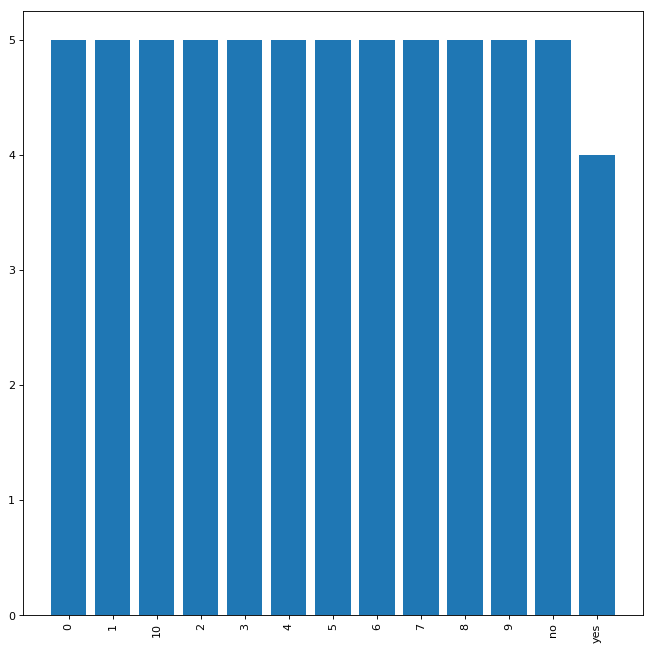

Each dataset for each answer is built by separated dataset. Why?
Each field of the answer is picked up separately so as to perform a specific preprocessing fucntion to the field we are considering.
Then Dataset of each field are recombined via [tf.data.Dataset.zip](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=stable#zip).

### test save locally features

In [ ]:

#obtain the dataset containing images
img_to_elab = os.listdir(os.path.join(PATH, 'train'))
dataset_path = tf.data.Dataset.from_tensor_slices(img_to_elab)


#dataset containing images
#high order function that load image from the disk and impose values between [0-1].
def get_image_loader(basepath):
    def image_loader(path):
       
        path = os.path.join(basepath ,path.decode("utf-8"))

        img = Image.open(path)
        img = img.resize((128,128 ))
        img = np.array(img)[:,:,:3]

        img = img * 1.0 / 255

        return img
    return image_loader

image_loader = get_image_loader(os.path.join(PATH, 'train'))

n_elements,dataset_image = myDataset(img_to_elab,
                             output_shapes   = (IMG_HEIGHT_SOURCE, IMG_WIDTH_SOURCE,3),
                             output_types    = tf.float32,
                             funct           = image_loader, 
                             seed            = None,
                             randomize         = False)

image_input = tf.keras.layers.Input((IMG_HEIGHT_SOURCE, IMG_WIDTH_SOURCE,3), name='img_input')
vision_model = tf.keras.applications.VGG19( include_top=False,weights='imagenet')
vision_model.trainable = False
vision_output = vision_model(image_input)
print(vision_output.shape)
vision_model = tf.keras.Model(inputs=image_input, outputs=vision_output )

import json
def append_to_json(_dict,path): 
    with open(path, 'ab+') as f:
        f.seek(0,2)                                #Go to the end of file    
        if f.tell() == 0 :                         #Check if file is empty
            f.write(json.dumps(_dict).encode())  #If empty, write an array
        else :
            f.seek(-1,2)           
            f.truncate()                           #Remove the last character, open the array
            f.write(' , '.encode())                #Write the separator
            f.write(json.dumps(_dict).encode())    #Dump the dictionary
            f.write('}'.encode())      
            
json_train_feature = {}
i = 0
j = 0
for b in zip(dataset_image.batch(batch_size)):
    res = vision_model.predict(b)
    for r in res:
        p = img_to_elab[i]
        json_train_feature[p] = r.tolist()
        i+=1
        j+=1
    if j >= 300:
        append_to_json(json_train_feature, 'train_precomputed.json')
        del json_train_feature 
        json_train_feature = {}
        j=0

In [35]:
#this function returns a dataset for a specific answer
def get_dataset_for_answer(data, ans=None,skip_ans=False, subpath='train', validation_split=0.2, 
                           subset='training', randomize=True):
    #define a filter so as to pick up only a specific type of answer
    def get_answer_selector(ans):
        def answer_selector(el):
            return el['answer']==ans
        return answer_selector
    
    if ans is not None:
        answer_selector = get_answer_selector(ans)
    else:
        answer_selector = None
        
    #dataset containing questions
    #high order function to encode question
    def get_encoder_question(t):
        def question_encoder(text):
            #use tokenizer to encode the sequences
            sequences = t.texts_to_sequences([text.decode("utf-8")])
            sequences = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
            return sequences[0]
        return question_encoder
        
    question_encoder = get_encoder_question(t)
    #obtain the dataset containing questions
    n_elements,dataset_questions = myDataset(data,field='question', 
                             output_shapes     = (MAX_SEQUENCE_LENGTH),
                             output_types      = tf.int32,
                             subset            = subset,
                             funct             = question_encoder, 
                             filt              = answer_selector,
                             validation_split  = validation_split, 
                             seed              = SEED,
                             randomize         = randomize)
    
    #dataset containing answers
    #high order function that encodes the answers with a custom format. 
    #This allows to tackle the problem both as a regression and a classification problem.
    
    def get_answer_encoder(classes):
        def answer_encoder(answer):
            answer = answer.decode('utf-8')
            if(CLASSIFICATION):
                return tf.one_hot([classes.index(answer)], depth=len(classes))[0]
            else:
                res = np.zeros(4)

                if answer == 'yes':
                    res[0] = 1
                elif answer == 'no':
                    res[1] = 1
                else :
                    res[2] = 1
                    res[3] = int(answer)

                return res
        return answer_encoder
    answer_encoder = get_answer_encoder(classes)
    #obtain the dataset containing answers
    if not skip_ans:
        _,dataset_answer = myDataset(data,
                                 field='answer', 
                                 output_shapes    = (len(classes)) if CLASSIFICATION else (4) ,
                                 output_types     = tf.float32,
                                 subset           = subset,
                                 funct            = answer_encoder, 
                                 filt             = answer_selector,
                                 validation_split = validation_split, 
                                 seed             = SEED,
                                 randomize         = randomize)

    #dataset containing images
    #high order function that load image from the disk and impose values between [0-1].
    def get_image_loader(basepath):
        def image_loader(path):
            path = os.path.join(basepath ,path.decode("utf-8"))
            img = tf.keras.preprocessing.image.load_img(path)
            #img = Image.open(path)
            #img = img.resize((IMG_WIDTH,IMG_HEIGHT ))
            img = np.array(img)[:,:,:3]

            img = img * 1.0 / 255

            return img
        return image_loader
    PATH_IMAGES = '/kaggle/input/clver-128x192/'
    image_loader = get_image_loader(os.path.join(PATH_IMAGES, subpath))
    #obtain the dataset containing images
    _,dataset_images = myDataset(data,field='image_filename', 
                             output_shapes   = (IMG_HEIGHT, IMG_WIDTH,3),
                             output_types    = tf.float32,
                             subset          = subset,
                             filt            = answer_selector,
                             funct           = image_loader, 
                             validation_split= validation_split, 
                             seed            = SEED,
                             randomize         = randomize)
    
    # ZIP datasets for a given answer
    dataset_res = tf.data.Dataset.zip((dataset_images,dataset_questions))
    if not skip_ans:
        dataset_res = tf.data.Dataset.zip((dataset_res,dataset_answer))
    number_steps = n_elements / batch_size 
    
    print('Number of batches',number_steps)
    #return the dataset for a given answer
    
    return dataset_res, n_elements

#obtain a training/validation dataset for each answer
training_datasets = []
validation_datasets = []
frequency_answers = []
tot_answers = 0
for ans in classes:
    print('obtaining dataset for',ans)
    dataset_ans, _ = get_dataset_for_answer(train_data,ans,subpath='files_clver_train/resized_train', subset='training')
    dataset_ans_val, n_elements = get_dataset_for_answer(train_data, ans, subpath='files_clver_train/resized_train',subset='validation')
    
    frequency_answers.append(n_elements)
    tot_answers += n_elements
    
    training_datasets.append(dataset_ans.shuffle(30).repeat())
    validation_datasets.append(dataset_ans_val)


#combine the datasets together 

frequency_dataset = np.array(frequency_answers) / tot_answers
#if you want to have a train dataset that is not umbalanced toward more frequent question

    
choice_dataset1 = tf.data.Dataset.range(len(classes)).repeat()
train_dataset_balanced = tf.data.experimental.choose_from_datasets(training_datasets, choice_dataset1).map(lambda x,y: (x,y), num_parallel_calls=20).batch( batch_size,drop_remainder=True )

train_dataset = tf.data.experimental.sample_from_datasets(training_datasets,frequency_dataset).map(lambda x,y: (x,y), num_parallel_calls=20).batch( batch_size,drop_remainder=True)

valid_dataset = tf.data.experimental.sample_from_datasets(validation_datasets,frequency_dataset).map(lambda x,y: (x,y), num_parallel_calls=20).batch( batch_size,drop_remainder=False )


obtaining dataset for 0
Number of batches 304.109375
Number of batches 76.03125
obtaining dataset for 1
Number of batches 361.921875
Number of batches 90.4765625
obtaining dataset for 10
Number of batches 0.1484375
Number of batches 0.0390625
obtaining dataset for 2
Number of batches 186.59375
Number of batches 46.6484375
obtaining dataset for 3
Number of batches 95.3515625
Number of batches 23.8359375
obtaining dataset for 4
Number of batches 46.359375
Number of batches 11.59375
obtaining dataset for 5
Number of batches 22.59375
Number of batches 5.6484375
obtaining dataset for 6
Number of batches 10.390625
Number of batches 2.59375
obtaining dataset for 7
Number of batches 4.046875
Number of batches 1.0078125
obtaining dataset for 8
Number of batches 1.6171875
Number of batches 0.40625
obtaining dataset for 9
Number of batches 0.65625
Number of batches 0.1640625
obtaining dataset for no
Number of batches 294.4921875
Number of batches 73.625
obtaining dataset for yes
Number of batches

In [36]:
it = iter(train_dataset)


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 11 12 18  7  3 17 33 31 23 39 31]
question ['how many rubber things are small blue cylinders or green cylinders']
image
answer (yes[binary], no[binary] , count[binary], number_regression[0-10]) tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)


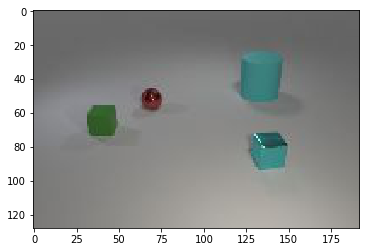

In [37]:
#example on how to obtain a data sample from the dataset

batch = next(it)
target_batch = batch[1]
input_batch  = batch[0]
sequences = input_batch[1]
images    = input_batch[0]
print(sequences[0].numpy())
print('question', t.sequences_to_texts([sequences[0].numpy()]))
print('image')
plt.figure()
plt.imshow(images[0])

print('answer (yes[binary], no[binary] , count[binary], number_regression[0-10])', target_batch[0])

In [ ]:
#example on how to obtain a data sample from the dataset

batch = next(it)
target_batch = batch[1]
input_batch  = batch[0]
sequences = input_batch[1]
images    = input_batch[0]
print(sequences[0].numpy())
print('question', t.sequences_to_texts([sequences[0].numpy()]))
print('image')
plt.figure()
plt.imshow(images[0])

print('answer (yes[binary], no[binary] , count[binary], number_regression[0-10])', target_batch[0])

# Model architecture

In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, LSTM, GRU, Embedding, Dense, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from tensorflow.keras.models import Model, Sequential

class LuongAttention(tf.keras.layers.Layer):
  def __init__(self):
    super(LuongAttention, self).__init__()

  def call(self, query, values):
    # inputs:
    # -    query comes from LSTM current output
    #      query shape == (batch_size, hidden size)
    # -    values comes from LSTM previous outputs 
    #      values shape == (batch_size, time_steps, hidden size)
    
    # we cannot ensure that these vector comes from the same 
    # LSTM cell, but at least w can ensure that they are compatible
    query = tf.expand_dims(query, axis=1)
    assert ( query.shape[2] == values.shape[2])
    
    # we are doing this to perform mat multiplication , which is 
    # another way to say that every vector inside values has to 
    # be scalarly multiplied with the query vector.
    # note: to avoid discrepncies due to the norm of the vectors
    #       we used normalization which means divide by the product of 
    #       the two norm. We obtain the cosine of the two vectors.
    scores = tf.keras.layers.dot([values, query], axes=2, normalize=True)
    #score shape == (batch_size, sequence_steps, 1)
    attention_weights = tf.nn.softmax(scores, axis=1)
    #attention_weights shape == (batch_size, sequence steps, 1)
    weigthed_values = attention_weights * values
    res             = tf.reduce_sum(weigthed_values, axis=1)

    return attention_weights ,  res


class RN(tf.keras.layers.Layer):
  def __init__(self):
    super(RN, self).__init__()
    self.g = Sequential()
    self.g.add(Dense(256, activation='relu'))
    self.g.add(Dense(256, activation='relu'))
    self.g.add(Dense(256, activation='relu'))
    self.g.add(Dense(256, activation='relu'))
    self.g = tf.keras.layers.TimeDistributed(self.g)
    
    self.f = Sequential()
    self.f.add(Dense(256, activation='relu'))
    self.f.add(Dropout(0.3))
    self.f.add(Dense(256, activation='relu'))
    self.f.add(Dropout(0.3))
 
    
  def call(self, feature, q):
    # inputs:
    # - feature dimension (batch, height, width ,features_channel )
    objects = []
    relations = []

    k = 35     # Hyperparameter which controls how many objects are considered

    # Get k unique random coordinate inside the feature map
    while k > 0:
        i = np.random.randint(0, feature.shape[1] - 1)
        j = np.random.randint(0, feature.shape[2] - 1)
        if not (i, j) in objects:
            objects.append([i, j])
            k -= 1

   
    for i in range(len(objects)):
        for j in range(i, len(objects)):
            # Extract feature maps related to those coordinate  
            # combinate those feature vector in every possible manner
            # note: avoided (i,i) due to the fact that we suppose 
            # a reflexive relationship
            coord_1 = objects[i]
            coord_2 = objects[j]
            obj_1 = feature[:,coord_1[0], coord_1[1],:]
            obj_2 = feature[:,coord_2[0], coord_2[1],:] #vector with (batch, feature)
            
            c1 = [2*coord_1[0]/feature.shape[1] -1,2*coord_1[1]/feature.shape[2]-1]
            c2 = [2*coord_2[0]/feature.shape[1] -1,2*coord_2[1]/feature.shape[2]-1]
            c1 = tf.repeat(tf.expand_dims(tf.constant(c1), axis=0),batch_size,axis=0)
            c2 = tf.repeat(tf.expand_dims(tf.constant(c2), axis=0),batch_size,axis=0)

            #combine those vector into a single vector with (batch, 2*feature)
            # this would then pass trhough a dense network
            conc = tf.concat([obj_1, obj_2, q, c1, c2], axis=1)
            #obtain a vector (batch, 1, 2*feature)
            conc = tf.expand_dims(conc, axis=1)
            relations.append(conc)
    #concatenate vectors previously constructed in a vector (batch, k, 2*feature)
    relation_tensor = tf.concat(relations, axis=1)
    scores          = self.g(relation_tensor) #output size (batch, k, #output_neurons_g)
    summation       = tf.reduce_sum(scores, axis=1)
    
    output = self.f(summation)
    return output

In [22]:
#attention based on LSTM context and CNN output:
class AttentionFeature(tf.keras.Model):
    def __init__(self, n_features):
        super(AttentionFeature, self).__init__()
        self.EXTRACT = tf.keras.layers.GlobalAveragePooling2D()
        #dense default activation is linear
        self.W1 = tf.keras.layers.Dense(1)
        self.SOFT = tf.keras.layers.Dense(n_features, activation='softmax')

    def call(self, features,hidden):
        #from features and hidden representation to a similarity factor
        mean_activation_per_feature = self.EXTRACT(features)
        hidden_per_feature          = self.W1(hidden)

        #obtain a similarity score
        #tf.multiply supports broadcasting https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
        score = tf.keras.layers.multiply([mean_activation_per_feature, hidden_per_feature])
        attention_weights =  self.SOFT(score)

        features_attentioned = tf.keras.layers.multiply([features, attention_weights])
        features_attentioned = tf.reduce_sum(features_attentioned, axis=3)

        return attention_weights, features_attentioned



In [23]:
#attention based on LSTM context and CNN output:
class AttentionFeatureTime(tf.keras.Model):
    def __init__(self, n_features):
        super(AttentionFeatureTime, self).__init__()
        self.EXTRACT = tf.keras.layers.GlobalAveragePooling2D()
        #dense default activation is linear
        self.W1 = tf.keras.layers.Dense(1)
        self.SOFT = tf.keras.layers.Dense(n_features, activation='softmax')

    def call(self, features,hidden):
        #from features and hidden representation to a similarity factor
        feature_seq = []
        mean_activation_per_feature = self.EXTRACT(features)
        for i in range(hidden.shape[1]):
            hidden_per_feature          = self.W1(hidden[:,i,:])

            #obtain a similarity score
            #tf.multiply supports broadcasting https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
            score = tf.keras.layers.multiply([mean_activation_per_feature, hidden_per_feature])
            attention_weights =  self.SOFT(score)

            features_attentioned = tf.keras.layers.multiply([features, attention_weights])
            features_attentioned = tf.reduce_sum(features_attentioned, axis=3)
            feature_seq.append(tf.expand_dims(features_attentioned, axis=-1))
            
        feature_seq = tf.concat(feature_seq, axis=-1)
        return attention_weights, feature_seq

In [24]:
def get_Vision_Model():
    PRETRAINED = True
    if not PRETRAINED:
        # Define CNN for Image Input
        vision_model = Sequential()
        vision_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
        vision_model.add(MaxPooling2D((2, 2)))
        vision_model.add(BatchNormalization())
        vision_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
        vision_model.add(MaxPooling2D((2, 2)))
        vision_model.add(BatchNormalization())
        vision_model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))
        vision_model.add(MaxPooling2D((2, 2)))
        vision_model.add(BatchNormalization())
        return vision_model
    else:
        vision_model = tf.keras.applications.vgg19.VGG19( include_top=False,weights='imagenet')
        vision_model.trainable = False
        return vision_model
    

In [25]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, feature_width*feature_height, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, feature_width*feature_height, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [26]:
image_input = Input((IMG_HEIGHT, IMG_WIDTH,3), name='img_input')
vision_output = get_Vision_Model()(image_input)
#once reshaped the vision output tensor can be considered as a regular sequence
vision_output = tf.reshape(vision_output, [-1, vision_output.shape[1]*vision_output.shape[2], vision_output.shape[3]])

# Define RNN for language input (batch_size, max_sequence_length)
question_input        = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input', dtype='int32')
embedded_question     = embedding_layer(question_input)
# embedding output shape = (batch_size, max_sequence, embedding_space_size )
# embedding output[batch_indx, time_step, specific_embedding_space_dimension]
embedded_question_dim = embedded_question.shape[2]

encoded_question      = Bidirectional(GRU(2*embedded_question_dim, return_sequences=True))(embedded_question)
cell_output_history, cell_output_final  = GRU(1*embedded_question_dim, return_sequences=True, return_state=True)(encoded_question)
encoded_question = cell_output_final

'''attention, encoded_question = LuongAttention()(cell_output_final, cell_output_history)'''

'''# Combine CNN and RNN to create the final model
for_head = RN()(vision_output, encoded_question)'''

'''attention_weights, feature1_seq = AttentionFeatureTime(vision_output.shape[3])(vision_output,cell_output_history)

print(feature1_seq.shape)
_, feature1 = AttentionFeature(feature1_seq.shape[3])(feature1_seq,encoded_question)
encoded_image1 = Flatten()(feature1)
merged = tf.keras.layers.concatenate([encoded_question, encoded_image1])
dense = Dense(64, activation='relu')(merged)
for_head = Dropout(0.3)(dense)
print(feature1.shape)'''

encoded_question,_ = BahdanauAttention(30)(cell_output_history, cell_output_final)

encode = []
for i in range(10):
    one_pixel,_ = BahdanauAttention(30)( vision_output, encoded_question)
    encode.append(one_pixel)

encode = tf.concat(encode, axis=-1)
dense = Dense(128, activation='relu')(encode)
dense = Dense(64, activation='relu')(dense)
for_head = Dropout(0.3)(dense)


#head of the NN.
if(CLASSIFICATION):
    output = Dense(len(classes), activation='softmax')(for_head)
else:
    output_classification = Dense(3, activation='softmax')(for_head)#3 = [yes, no, regression]
    output_regression     = Dense(1)(for_head)#1 output unbounded
    lower_bound           = tf.zeros_like(output_regression)
    output_regression     = tf.keras.layers.Maximum()([output_regression, lower_bound])
    higher_bound          = tf.ones_like(output_regression)*10.0
    output_regression     = tf.keras.layers.Minimum()([output_regression, higher_bound])
    output = Concatenate()([output_classification, output_regression])

vqa_model = Model(inputs=[image_input, question_input], outputs=output)

80142336/80134624 [==============================] - 2s 0us/step


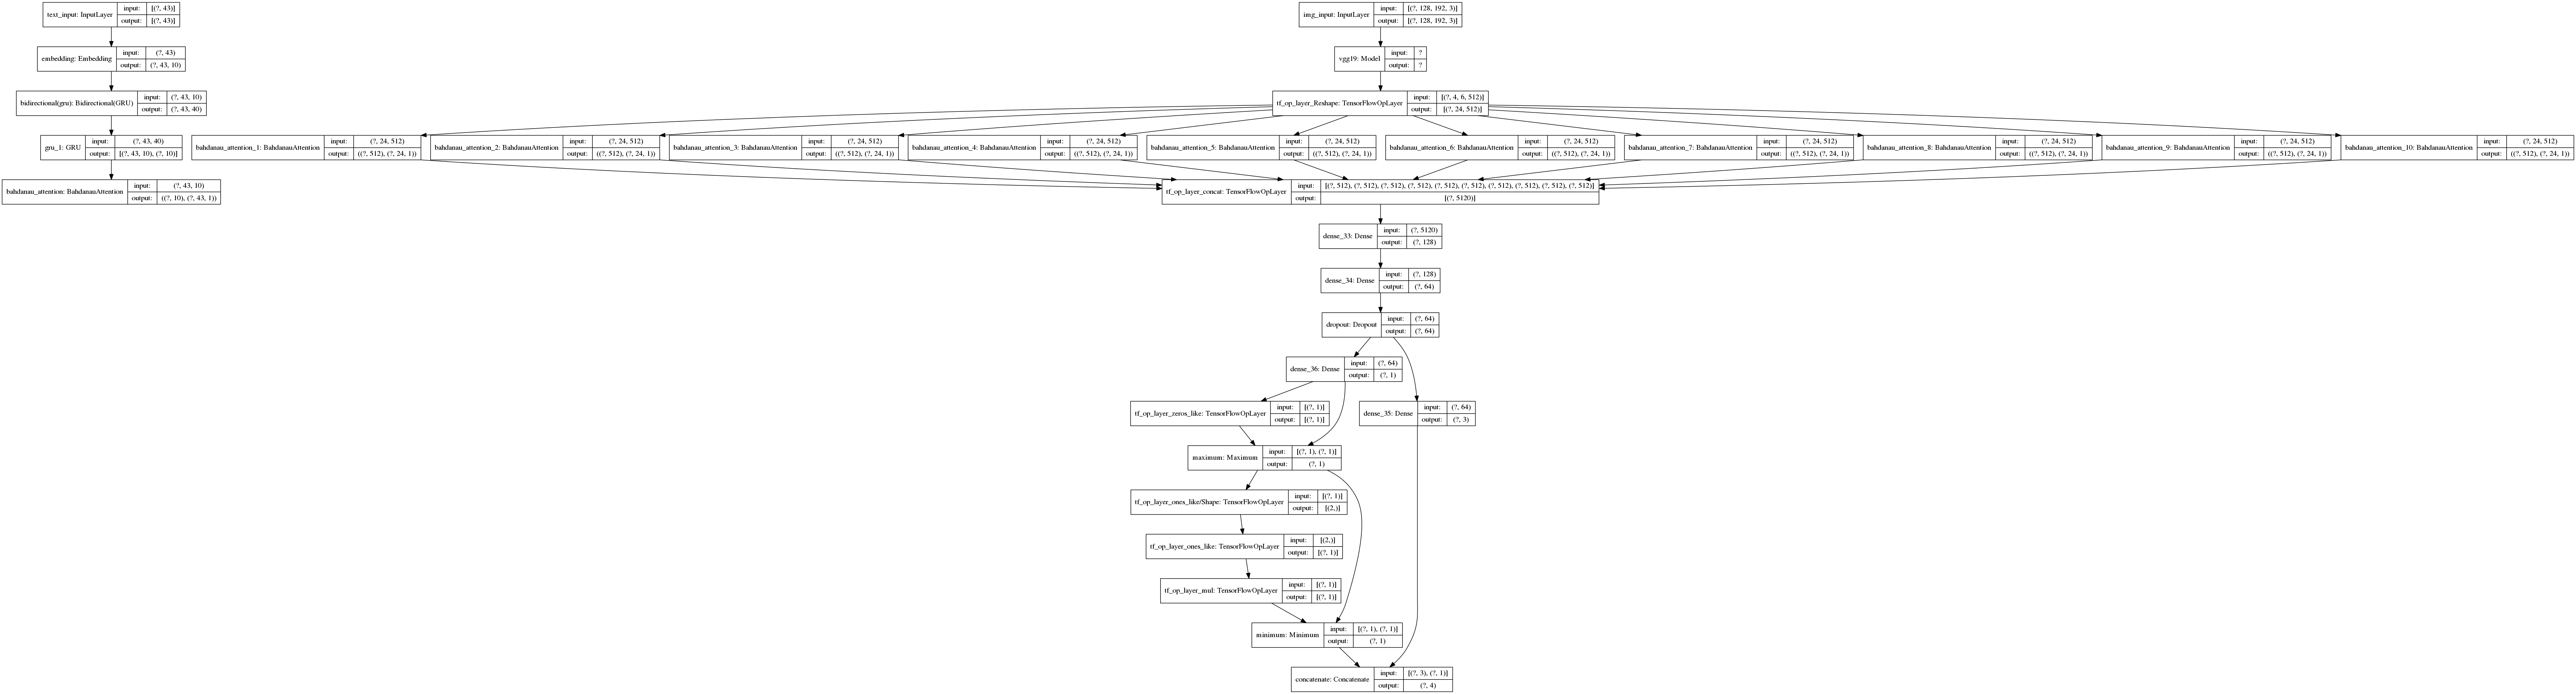

In [27]:
plot_model(vqa_model, show_shapes=True)

In [28]:
vqa_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 10)       730         text_input[0][0]                 
__________________________________________________________________________________________________
img_input (InputLayer)          [(None, 128, 192, 3) 0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 43, 40)       3840        embedding[0][0]                  
______________________________________________________________________________________________

## Custom loss
since has beem decided to tackle the problem as both a classification and regression problem a custom loss was required.

The output of the NN has been encoded as follows:
- binary 1hot encoding 'yes'
- binary 1hot encoding 'no'
- binary 1hot encoding 'regression_problem'
- regression output ranging from 0 to 1 , representing numbers between 0 to 10.

The loss function is a combination of categorical cross entropy and MSE. The MSE term is considered only when the expected answer refer to a counting problem, that is when the third one hot is active. 
inspiration from [FasterRCnn](https://arxiv.org/abs/1506.01497)

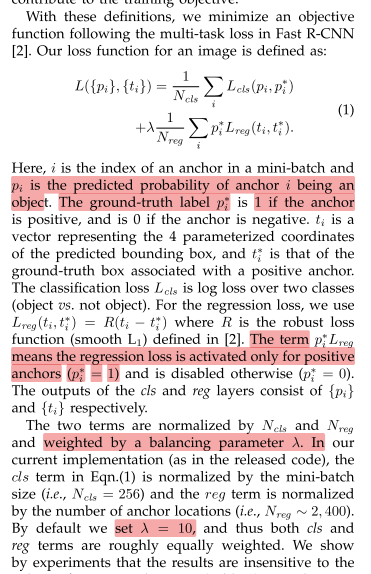

In [29]:
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.losses import categorical_crossentropy
# Function used to extract categorical and regression term when y related
# to a single sample
def custom_encod2cat_reg(y):
    #ytrue/ypred is made of 4 numbers
    # - binary 1hot encoding 'yes'
    # - binary 1hot encoding 'no'
    # - binary 1hot encoding 'regression_problem'
    # - regression output ranging from 0 to 1 , but representing 0 to 10.
    
    cat, regr = tf.split(y, [3, 1], axis=0)
   
    return cat, regr

# Function used to extract categorical and regression term when y related
# to a batch
def custom_encods2cat_reg(y):
    #ytrue/ypred is made of 4 numbers
    # - binary 1hot encoding 'yes'
    # - binary 1hot encoding 'no'
    # - binary 1hot encoding 'regression_problem'
    # - regression output ranging from 0 to 1 , but representing 0 to 10.
    
    cat, regr = tf.split(y, [3, 1], axis=1)
   
    return cat, regr

#custom loss
def loss(y_true, y_pred):
    
    #move from custom encoding to separated component (categorical and regression components)
    cat_y_true, regr_y_true = custom_encods2cat_reg(y_true)
    cat_y_pred, regr_y_pred = custom_encods2cat_reg(y_pred)
    # from t_true categorical extract the 1-hot that express whether the answer
    # was a regression or not for later usage
    
    _, cat_y_true_reg = tf.split(cat_y_true, [2, 1], axis=1)
    w = 1
    # sum the loss of two components categorical and regression
    # regression is only considered when the answer was truly related to regression (counting)
    # inspiration from FasterR-CNN with the loss related to bounding box regression and "objectness" measure
    reg_loss = cat_y_true_reg * w *mean_squared_error(regr_y_true, regr_y_pred)
    
    #reg_loss = cat_y_true_reg *w *tf.keras.losses.mean_absolute_error(regr_y_true, regr_y_pred)
    
    loss = 10*10/14*categorical_crossentropy(cat_y_true, cat_y_pred) + 10*4/14*reg_loss
    
    return loss

In [30]:
#example of usage
print (loss([[0,0,1,0.1]], [[0,0,1,0.8]]))

print( loss([[0,0,1,0.1]], [[0,0.9,0,0.8]]))

tf.Tensor([[1.4000008]], shape=(1, 1), dtype=float32)
tf.Tensor([[116.52925]], shape=(1, 1), dtype=float32)


## Custom metric
Since the encoding differs from the one used to evaluate the work on kaggle we have to
return to the original encoding before supply the tensors to categorical_accuracy function.


In [31]:
from tensorflow.keras.metrics import categorical_accuracy
#Function used to move from custom encoding back to the original encoding used in 
# the Kaggle competition. Used in case y relates to a single sample
def custom_encod2cat(y):
    # extract categorical and regression terms out of the custom encoding
    cat_y, regr_y = custom_encod2cat_reg(y)
    #separate in from the categorical part of the output the one hot related to 
    # - indicates yes 
    # - indicates no
    # - indicates a regression
    cat_yes, cat_no ,cat_regr= tf.split(cat_y, [1,1,1], axis=0)
    
    # move from regression output to one hot between 11 classes
        
    regr_one_hot = tf.reshape(tf.one_hot( tf.cast(tf.math.round(regr_y), tf.uint8), 11), [-1])
    # multiply with one hot that indicates whether this was a regression problem or not
    # so as to eliminate regression one hot in case cat_regr is low
    regr_one_hot = cat_regr * regr_one_hot
    
    #rearrange one hots to reflect the output expected by the kaggle competition    
    reg_01, regr_29 ,regr_10= tf.split(regr_one_hot, [2,8,1], axis=0)
    categorical = tf.concat([reg_01, regr_10, regr_29, cat_no, cat_yes ], axis=0)
   
    return categorical

#Function used to move from custom encoding back to the original encoding used in 
# the Kaggle competition. Used in case y relates to a batch
def custom_encods2cat(ys):
    
    return tf.map_fn(custom_encod2cat, ys)
    
    

#custom metric "adapter"
def metric(y_true, y_pred):
    
    y_true = custom_encods2cat(y_true)
    y_pred = custom_encods2cat(y_pred)
    
    return categorical_accuracy(y_true, y_pred)

In [32]:
#test of usage
for p in range(1,11):
    for num in range(11):
        assert np.argmax(custom_encod2cat([p/10 -0.1,p/10-0.1,p/10,num])) == classes.index(str(num)) 


In [33]:
# Optimization parameters

lr = 1e-2
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [metric]
# Compile Model (change the name for each model)
if(CLASSIFICATION):
    vqa_model.compile(optimizer=optimizer, loss=tf.keras.losses.categorical_crossentropy, metrics=[tf.keras.metrics.categorical_accuracy])
else:
    vqa_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [34]:
#train first with a balanced dataset

history = vqa_model.fit(
              train_dataset_balanced.prefetch(tf.data.experimental.AUTOTUNE),
              steps_per_epoch = 75,
              epochs=20,
              validation_freq = 1,
              validation_data=valid_dataset.prefetch(tf.data.experimental.AUTOTUNE),
              validation_steps = 15
          )

Train for 75 steps, validate for 15 steps
Epoch 1/20
75/75 [==============================] - 59s 783ms/step - loss: 125.7294 - metric: 0.0774 - val_loss: 195.0521 - val_metric: 0.0000e+00
Epoch 2/20
75/75 [==============================] - 42s 557ms/step - loss: 126.4697 - metric: 0.0769 - val_loss: 195.0521 - val_metric: 0.0000e+00
Epoch 3/20
75/75 [==============================] - 41s 550ms/step - loss: 126.5299 - metric: 0.0770 - val_loss: 195.0521 - val_metric: 0.0000e+00
Epoch 4/20
75/75 [==============================] - 41s 548ms/step - loss: 126.4550 - metric: 0.0769 - val_loss: 195.0521 - val_metric: 0.0000e+00
Epoch 5/20
75/75 [==============================] - 38s 510ms/step - loss: 126.5416 - metric: 0.0770 - val_loss: 195.0521 - val_metric: 0.0000e+00
Epoch 6/20
29/75 [==========>...................] - ETA: 17s - loss: 126.4531 - metric: 0.0767

KeyboardInterrupt: 

In [ ]:
#fine tune the architecture with a dataset that reflect the class imbalance
#in the data.
history = vqa_model.fit(
              train_dataset.prefetch(tf.data.experimental.AUTOTUNE),
              steps_per_epoch = 75,
              epochs=40,
              validation_freq = 1,
              validation_data=valid_dataset.prefetch(tf.data.experimental.AUTOTUNE),
              validation_steps = 15
          )

In [ ]:
75/75 [==============================] - 112s 1s/step - loss: 3.1147 - metric: 0.4578 - val_loss: 3.0325 - val_metric: 0.4568

In [ ]:
# Load the extension and start TensorBoard

%load_ext tensorboard
%tensorboard --logdir logs/train

In [ ]:
Train for 100 steps, validate for 20 steps
Epoch 1/40
100/100 [==============================] - 250s 2s/step - loss: 8.2577 - categorical_accuracy: 0.1814 - val_loss: 1.9549 - val_categorical_accuracy: 0.1750
Epoch 2/40
100/100 [==============================] - 138s 1s/step - loss: 1.9242 - categorical_accuracy: 0.2391 - val_loss: 1.4830 - val_categorical_accuracy: 0.3313
Epoch 3/40
100/100 [==============================] - 138s 1s/step - loss: 1.4320 - categorical_accuracy: 0.3847 - val_loss: 1.2695 - val_categorical_accuracy: 0.4164
Epoch 4/40
100/100 [==============================] - 136s 1s/step - loss: 1.3129 - categorical_accuracy: 0.3775 - val_loss: 1.2351 - val_categorical_accuracy: 0.4016
Epoch 5/40
100/100 [==============================] - 133s 1s/step - loss: 1.2450 - categorical_accuracy: 0.4048 - val_loss: 1.1755 - val_categorical_accuracy: 0.4117
Epoch 6/40
100/100 [==============================] - 129s 1s/step - loss: 1.1851 - categorical_accuracy: 0.4259 - val_loss: 1.1408 - val_categorical_accuracy: 0.4336
Epoch 7/40
100/100 [==============================] - 129s 1s/step - loss: 1.2002 - categorical_accuracy: 0.4192 - val_loss: 1.1305 - val_categorical_accuracy: 0.4297
Epoch 8/40
100/100 [==============================] - 127s 1s/step - loss: 1.1730 - categorical_accuracy: 0.4116 - val_loss: 1.1285 - val_categorical_accuracy: 0.4477
Epoch 9/40
100/100 [==============================] - 127s 1s/step - loss: 1.1558 - categorical_accuracy: 0.4261 - val_loss: 1.1224 - val_categorical_accuracy: 0.4313
Epoch 10/40
100/100 [==============================] - 128s 1s/step - loss: 1.1524 - categorical_accuracy: 0.4258 - val_loss: 1.1145 - val_categorical_accuracy: 0.4203
Epoch 11/40
100/100 [==============================] - 127s 1s/step - loss: 1.1261 - categorical_accuracy: 0.4344 - val_loss: 1.0998 - val_categorical_accuracy: 0.4539
Epoch 12/40
100/100 [==============================] - 127s 1s/step - loss: 1.1237 - categorical_accuracy: 0.4394 - val_loss: 1.1105 - val_categorical_accuracy: 0.4328
Epoch 13/40
100/100 [==============================] - 127s 1s/step - loss: 1.1302 - categorical_accuracy: 0.4408 - val_loss: 1.1194 - val_categorical_accuracy: 0.4336
Epoch 14/40
100/100 [==============================] - 128s 1s/step - loss: 1.1472 - categorical_accuracy: 0.4241 - val_loss: 1.1200 - val_categorical_accuracy: 0.4313
Epoch 15/40
100/100 [==============================] - 128s 1s/step - loss: 1.1396 - categorical_accuracy: 0.4289 - val_loss: 1.1230 - val_categorical_accuracy: 0.4313
Epoch 16/40
100/100 [==============================] - 127s 1s/step - loss: 1.1153 - categorical_accuracy: 0.4395 - val_loss: 1.1057 - val_categorical_accuracy: 0.4570
Epoch 17/40
100/100 [==============================] - 128s 1s/step - loss: 1.1268 - categorical_accuracy: 0.4322 - val_loss: 1.1079 - val_categorical_accuracy: 0.4227
Epoch 18/40
100/100 [==============================] - 127s 1s/step - loss: 1.1019 - categorical_accuracy: 0.4470 - val_loss: 1.0935 - val_categorical_accuracy: 0.4344
Epoch 19/40
100/100 [==============================] - 128s 1s/step - loss: 1.1118 - categorical_accuracy: 0.4495 - val_loss: 1.1380 - val_categorical_accuracy: 0.4422
Epoch 20/40
100/100 [==============================] - 128s 1s/step - loss: 1.0929 - categorical_accuracy: 0.4559 - val_loss: 1.0840 - val_categorical_accuracy: 0.4516
Epoch 21/40
100/100 [==============================] - 128s 1s/step - loss: 1.1014 - categorical_accuracy: 0.4509 - val_loss: 1.1026 - val_categorical_accuracy: 0.4602
Epoch 22/40
100/100 [==============================] - 129s 1s/step - loss: 1.1027 - categorical_accuracy: 0.4466 - val_loss: 1.0952 - val_categorical_accuracy: 0.4594
Epoch 23/40
100/100 [==============================] - 129s 1s/step - loss: 1.1056 - categorical_accuracy: 0.4561 - val_loss: 1.1079 - val_categorical_accuracy: 0.4359
Epoch 24/40
100/100 [==============================] - 129s 1s/step - loss: 1.1099 - categorical_accuracy: 0.4445 - val_loss: 1.1062 - val_categorical_accuracy: 0.4359
Epoch 25/40
100/100 [==============================] - 129s 1s/step - loss: 1.1082 - categorical_accuracy: 0.4542 - val_loss: 1.0926 - val_categorical_accuracy: 0.4664
Epoch 26/40
 99/100 [============================>.] - ETA: 0s - loss: 1.0992 - categorical_accuracy: 0.4457

In [ ]:
Train for 100 steps, validate for 20 steps
Epoch 1/40
100/100 [==============================] - 157s 2s/step - loss: 27.3903 - metric: 0.0772 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 2/40
100/100 [==============================] - 133s 1s/step - loss: 27.5371 - metric: 0.0769 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 3/40
100/100 [==============================] - 135s 1s/step - loss: 27.5491 - metric: 0.0769 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 4/40
100/100 [==============================] - 133s 1s/step - loss: 27.5368 - metric: 0.0770 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 5/40
100/100 [==============================] - 124s 1s/step - loss: 27.5328 - metric: 0.0769 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 6/40
100/100 [==============================] - 119s 1s/step - loss: 27.5560 - metric: 0.0769 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 7/40
100/100 [==============================] - 118s 1s/step - loss: 27.5215 - metric: 0.0770 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 8/40
100/100 [==============================] - 120s 1s/step - loss: 27.5427 - metric: 0.0769 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 9/40
100/100 [==============================] - 120s 1s/step - loss: 27.5487 - metric: 0.0769 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 10/40
100/100 [==============================] - 119s 1s/step - loss: 27.5320 - metric: 0.0770 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 11/40
100/100 [==============================] - 91s 912ms/step - loss: 27.5407 - metric: 0.0769


In [ ]:
vqa_model.save_weights('weights.h5')

In [ ]:
vqa_model.evaluate(valid_dataset)

In [ ]:
with lst+Attention+2feature extracted by cnn(vgg19) and attention 
Train for 400 steps, validate for 30 steps
Epoch 1/40
400/400 [==============================] - 456s 1s/step - loss: 3.7495 - metric: 0.2298 - val_loss: 1.9585 - val_metric: 0.2859
Epoch 2/40
400/400 [==============================] - 434s 1s/step - loss: 2.7119 - metric: 0.2842 - val_loss: 6.2830 - val_metric: 0.1203
Epoch 3/40
400/400 [==============================] - 432s 1s/step - loss: 6.3343 - metric: 0.1217 - val_loss: 6.0117 - val_metric: 0.1245
Epoch 4/40
400/400 [==============================] - 457s 1s/step - loss: 3.5880 - metric: 0.1938 - val_loss: 2.7448 - val_metric: 0.2302
Epoch 5/40
400/400 [==============================] - 453s 1s/step - loss: 1.8468 - metric: 0.3146 - val_loss: 1.8292 - val_metric: 0.3375
Epoch 6/40
400/400 [==============================] - 441s 1s/step - loss: 1.5372 - metric: 0.3557 - val_loss: 1.6639 - val_metric: 0.3271
Epoch 7/40
400/400 [==============================] - 439s 1s/step - loss: 1.4580 - metric: 0.3636 - val_loss: 1.7018 - val_metric: 0.3208
Epoch 8/40
400/400 [==============================] - 436s 1s/step - loss: 1.3808 - metric: 0.3802 - val_loss: 1.4699 - val_metric: 0.3594
Epoch 9/40
400/400 [==============================] - 439s 1s/step - loss: 1.3452 - metric: 0.3828 - val_loss: 1.6619 - val_metric: 0.3448
Epoch 10/40
400/400 [==============================] - 439s 1s/step - loss: 1.3126 - metric: 0.3847 - val_loss: 1.5265 - val_metric: 0.3630
Epoch 11/40
400/400 [==============================] - 439s 1s/step - loss: 1.3005 - metric: 0.3909 - val_loss: 1.6439 - val_metric: 0.3500
Epoch 12/40
276/400 [===================>..........] - ETA: 2:05 - loss: 1.2393 - metric: 0.4021







# Evaluate results

In [ ]:
# Code snippet used in a first time to evaluate
# models' capabilities. In particular was used to try spotting correlations
# between errors both on the training and on the validation dataset.

def computeConfusion(dataset, max_num ):
    confusion_matrix = [[ 0 for i in range(0,len(classes))] for i in range(0,len(classes))];

    it = iter(dataset)
    i = 0;
    while( i < max_num):
        batch = next(it)
        sample = batch[0]
        labels = batch[1]
        for j,l in enumerate(labels):

            if(i > max_num):
                break;
    
            res = vqa_model.predict((tf.expand_dims(sample[0][j], axis=0), tf.expand_dims(sample[1][j], axis=0)) )
            if not CLASSIFICATION:
                l = custom_encod2cat(l)
                res = custom_encods2cat(res)
                
            expected = np.argmax(l)
            predicted = np.argmax(res[0]);
            
            confusion_matrix[expected][predicted] +=1
            i+=1

    plotConfusionMatrix(confusion_matrix);
      
def plotConfusionMatrix(conf):
    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    im = plt.imshow(conf)
    plt.yticks(range(0,len(classes)), labels=classes);
    plt.xticks(range(0,len(classes)), labels=classes, rotation='vertical' );
    plt.ylabel("expected");
    plt.xlabel("predicted");
    plt.gca().invert_yaxis()
    plt.colorbar();

    for y in range(len(conf)):
        for x in range(len(conf[y])):
            plt.text(x, y , '{:.0f}'.format(conf[y][x]),
                  color='w',horizontalalignment='center',
                  verticalalignment='center')


computeConfusion(train_dataset, 10);
computeConfusion(valid_dataset, 10);

In [ ]:
# The following code snippet was used to have an idea on 
# dataset distribution across the classes.
def plotDatasetDistribution(dataset, max_num ):
    classes_count = [0 for i in range(len(classes))]

    it = iter(dataset)
    i = 0;
    while( i < max_num):
        batch = next(it)
        labels = batch[1]
        for l in labels:
            if(i > max_num):
                break
            if not CLASSIFICATION:
                l = custom_encod2cat(l)
            expected = np.argmax(l)
            classes_count[expected]+=1
            i+=1
    #print(classes_count)
    plt.figure( figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k');
    plt.bar(range(len(classes)), classes_count )
    plt.xticks( ticks=range(len(classes)) ,labels=classes, rotation='vertical' )
    plt.show()

plotDatasetDistribution(train_dataset, 10)
plotDatasetDistribution(valid_dataset, 10)

In [ ]:
import gc
del train_dataset_cached
gc.collect()

# Collecting predictions

In [38]:
#we can obtain a dataset in the same way we have done for the training_testset
dataset_test,_ = get_dataset_for_answer(test_data,ans=None, skip_ans=True, subpath='files_clver_test/resized_test',
                                      subset='training', validation_split=0.0, randomize=False)
#Keras conventions require that inputs to model predict are
# tuples (input, None)
# in our specific case
# tuples ( (img_input, text_input) , None)

dataset_test = tf.data.Dataset.zip((dataset_test,)).batch(batch_size)

Number of batches 23.4375


In [39]:
test_data[:4]

[{'question_id': 0,
  'image_filename': 'CLEVR_val_009641.png',
  'question': 'are there any tiny green things made of the same material as the small brown sphere ? '},
 {'question_id': 1,
  'image_filename': 'CLEVR_val_010849.png',
  'question': 'are there any purple metal things of the same size as the green shiny object ? '},
 {'question_id': 2,
  'image_filename': 'CLEVR_val_004213.png',
  'question': 'is there a big thing of the same color as the big metal ball ? '},
 {'question_id': 3,
  'image_filename': 'CLEVR_val_012597.png',
  'question': 'there is a big metallic thing to the right of the blue rubber object ;  are there any small cyan rubber blocks that are to the right of it ? '}]

(128, 128, 192, 3) (128, 43)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 11 12 18  7  3 17 33 31 23 39 31]
question ['how many rubber things are small blue cylinders or green cylinders']
image


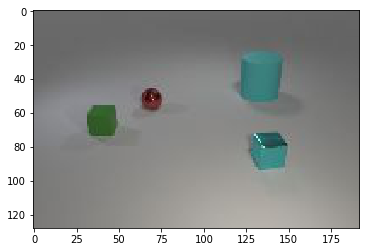

In [40]:
#check that the conventions are respected
it = iter(dataset_test)

input_batch  = batch[0]

sequences = input_batch[1]
images    = input_batch[0]

print(images.shape, sequences.shape)
#check elements order is respected
print(sequences[0].numpy())
print('question', t.sequences_to_texts([sequences[0].numpy()]))
print('image')
plt.figure()
plt.imshow(images[0])


In [41]:
#predict from dataset
answers = vqa_model.predict(dataset_test)
#answers is a vector of outputs 

In [ ]:
print('answers',answers[:4])
# a fast check that all answers have been all collected
assert(len(answers) == len (test_data))

if not CLASSIFICATION:
    cat_anwers = custom_encods2cat(answers)
else:
    cat_anwers = answers
    
print('categorized',cat_anwers[:4])
num_answers = tf.argmax(cat_anwers,axis=1)
print(num_answers[:4])
print(len(num_answers), len(test_data))
assert(len(num_answers) == len (test_data))

In [ ]:
results = {}
for i,el in enumerate(num_answers):
    results[i] = el.numpy()

In [ ]:
res_bin = np.zeros(len(classes))
for k in results:
    res_bin[results[k]] +=1

In [ ]:
plt.plot(res_bin)

%44
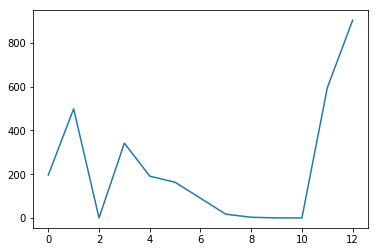

%46 accuracy
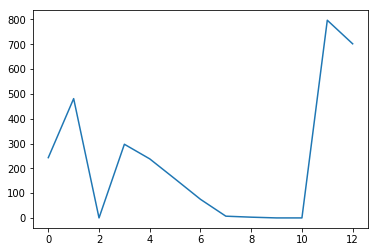

In [ ]:
results

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(str(key) + ',' + str(value) + '\n')

create_csv(results)